In [19]:
install.packages("Matching")
library(Matching)

Installing package into ‘/home/zmeckla/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


## 
##  Matching (Version 4.10-15, Build Date: 2024-10-14)
##  See https://www.jsekhon.com for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




In [2]:
install.packages("WeightIt")
library(dplyr)
library(readr)
library(ggplot2)
library(MatchIt)
library(WeightIt)

full.2014 <- read_csv("../data/output/data-2014.csv")
full.2015 <- read_csv("../data/output/data-2015.csv")
full.2016 <- read_csv("../data/output/data-2016.csv")
full.2017 <- read_csv("../data/output/data-2017.csv")
full.2018 <- read_csv("../data/output/data-2018.csv")
full.2019 <- read_csv("../data/output/data-2019.csv")

ma_all <- bind_rows(full.2014, full.2015, full.2016,
                    full.2017, full.2018, full.2019)

Installing package into ‘/home/zmeckla/R/x86_64-conda-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Rows: 49892 Columns: 69
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (52): planid, fips, year.x, n_nonmiss, avg_enrollment, sd_enrollment, mi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 51115 Columns: 69
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (17): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (52): planid, fips, year.x, n_nonmiss, avg_enrollment, s

In [3]:
plan_counts_contract <- ma_all %>%
  filter(!is.na(year)) %>%
  distinct(year, fips, contractid) %>%
  group_by(year, fips) %>%
  summarise(plan_count = n(), .groups = "drop")

plan_counts_contract %>%
  arrange(desc(plan_count)) %>%
  head(10)

year,fips,plan_count
<dbl>,<dbl>,<int>
2014,12011,77
2014,12099,74
2014,4013,72
2015,6037,72
2014,6037,70
2015,36047,70
2015,12011,69
2015,36061,69
2014,12086,68


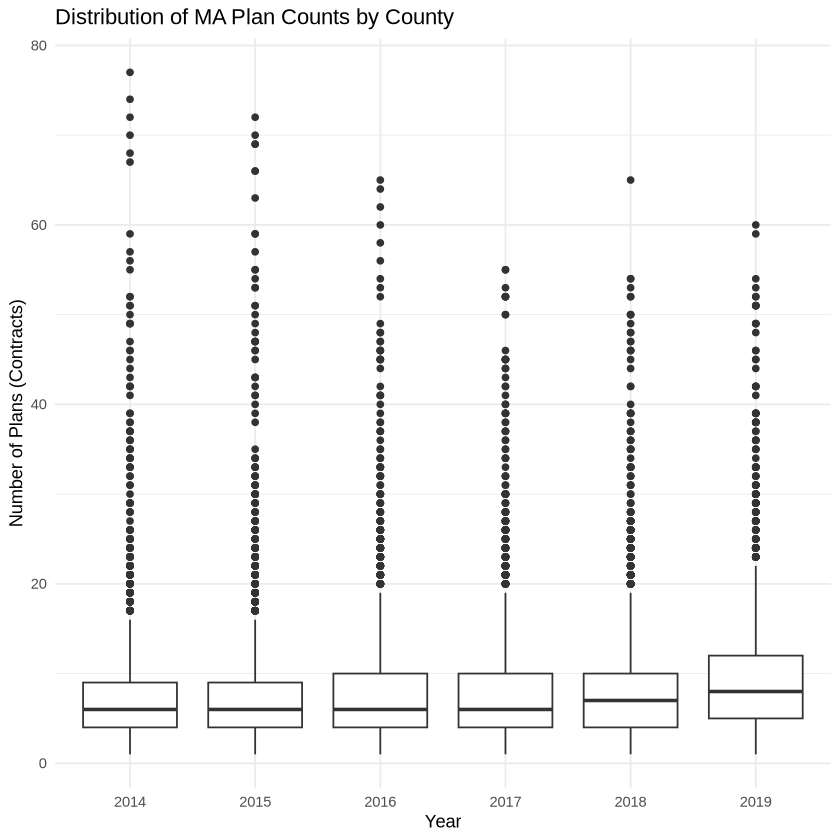

In [4]:
#300+ plans cuz counting contractid + planid (every plan variant) vs Dr. McCarthy counting contract-level plans (unique contractid per county)
plan_counts <- ma_all %>%
  filter(!is.na(year)) %>%                     # remove accidental NA year
  distinct(year, fips, contractid) %>%         # count unique contracts
  group_by(year, fips) %>%
  summarise(plan_count = n(), .groups = "drop")

#Boxplot
ggplot(plan_counts, aes(x = factor(year), y = plan_count)) +
  geom_boxplot() +
  labs(
    title = "Distribution of MA Plan Counts by County",
    x = "Year",
    y = "Number of Plans (Contracts)"
  ) +
  theme_minimal()

#Interpretation: This number of plans is likely too many and may cause decision fatigue. 

Warning message:
“Removed 7635 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 7185 rows containing non-finite outside the scale range (`stat_bin()`).”


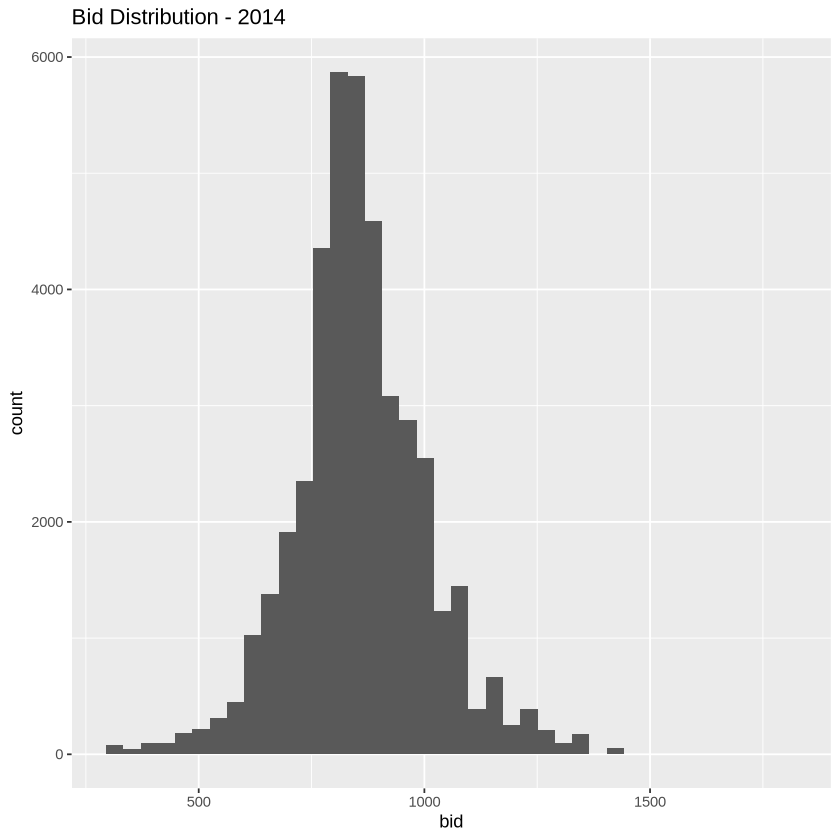

year,mean_bid,sd_bid
<dbl>,<dbl>,<dbl>
2014,858.1218,148.7249
2018,768.4633,121.4392


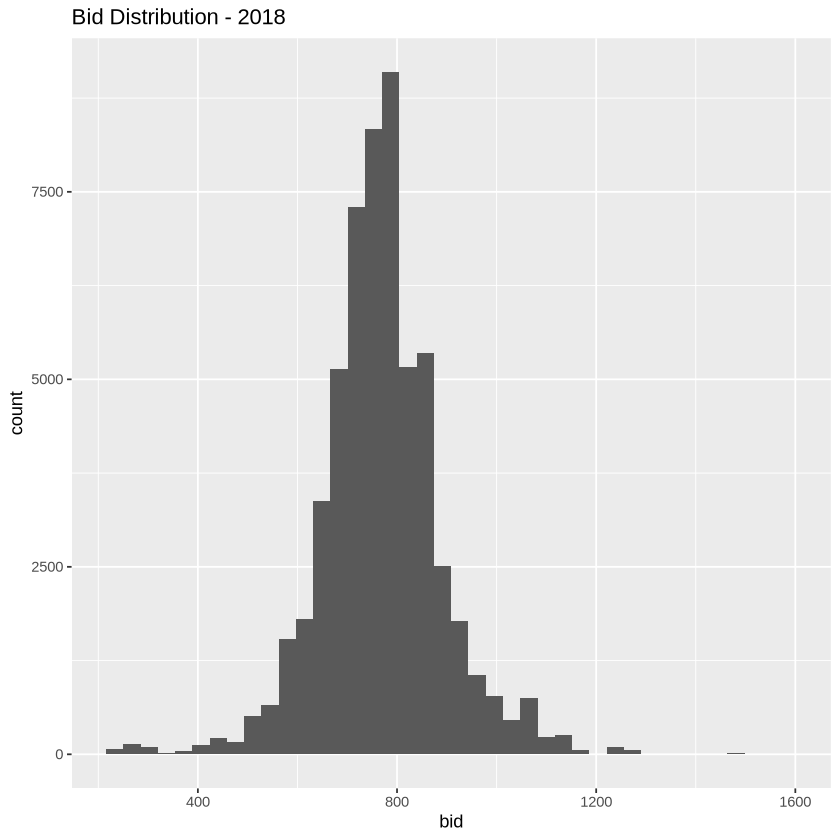

In [5]:
##Q2
ggplot(filter(ma_all, year == 2014),
       aes(x = bid)) +
  geom_histogram(bins = 40) +
  labs(title = "Bid Distribution - 2014")

ggplot(filter(ma_all, year == 2018),
       aes(x = bid)) +
  geom_histogram(bins = 40) +
  labs(title = "Bid Distribution - 2018")
ma_all %>%
  filter(year %in% c(2014, 2018)) %>%
  group_by(year) %>%
  summarise(
    mean_bid = mean(bid, na.rm=TRUE),
    sd_bid   = sd(bid, na.rm=TRUE)
  )

#Interpretation: How has this distribution changed over time? Mean bid has decreased over time. 

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


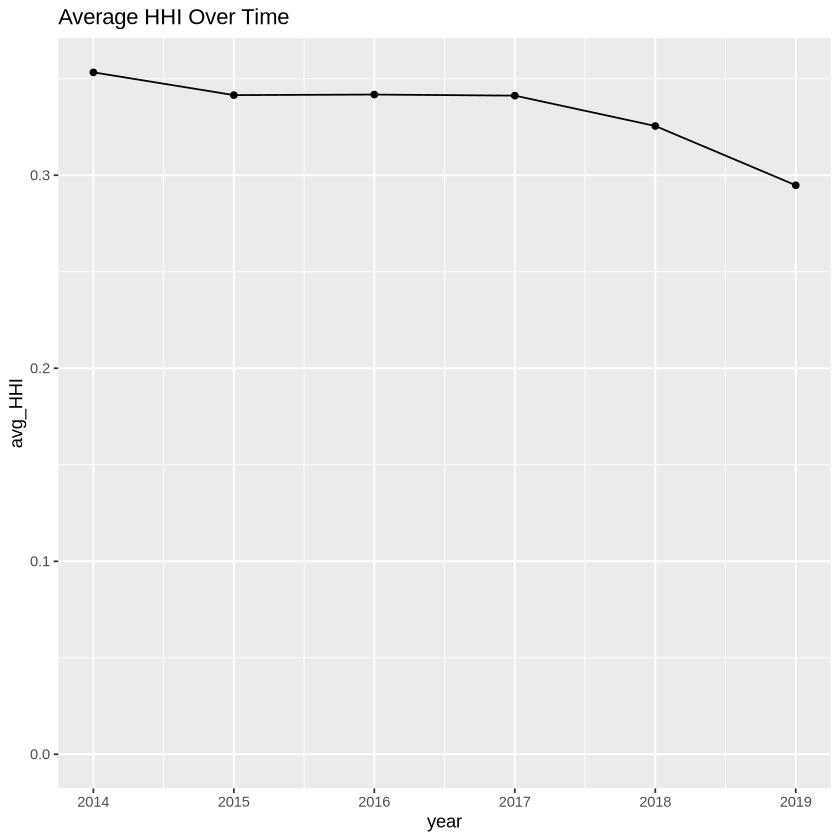

In [6]:
##Q3
hhi_data <- ma_all %>%
  group_by(year, fips) %>%
  mutate(
    share = last_enrollment / sum(last_enrollment, na.rm=TRUE)
  ) %>%
  summarise(
    HHI = sum(share^2, na.rm=TRUE),
    .groups="drop"
  )

#Avg HHI/year
avg_hhi <- hhi_data %>%
  group_by(year) %>%
  summarise(avg_HHI = mean(HHI, na.rm=TRUE))

#Plot
ggplot(avg_hhi, aes(x = year, y = avg_HHI)) +
  geom_line() +
  geom_point() +
  labs(title = "Average HHI Over Time")

#Interpretation: How has the HHI changed over time? Average HHI has decreased over time, especially in 2018 and 2019. 

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


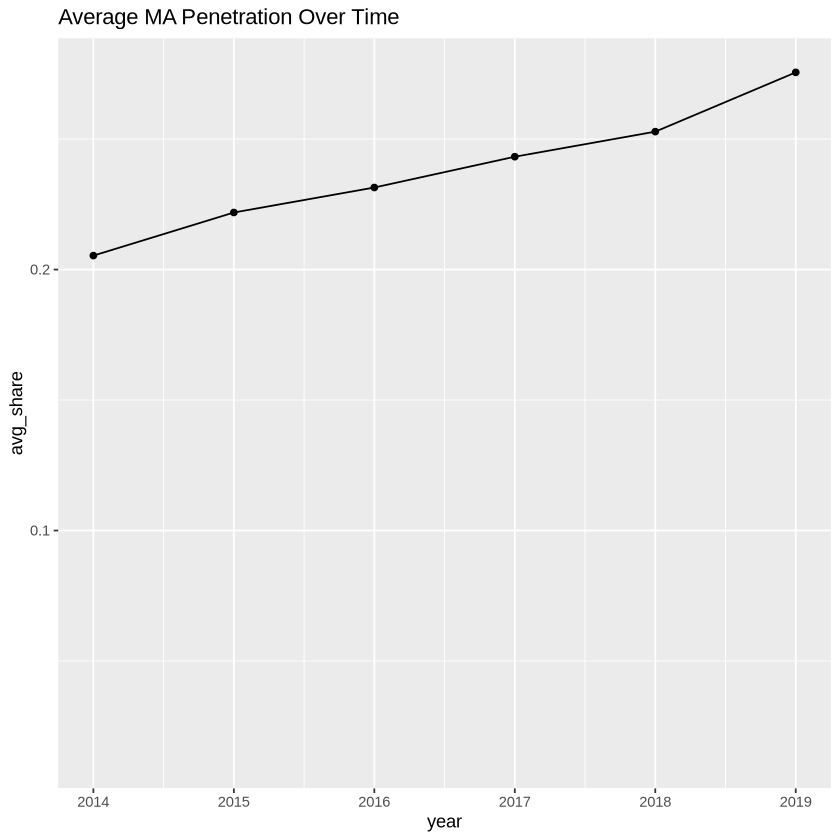

In [7]:
##Q4
ma_share <- ma_all %>%
  group_by(year, fips) %>%
  summarise(
    ma_share = mean(avg_enrolled / avg_eligibles, na.rm=TRUE),
    .groups="drop"
  ) %>%
  group_by(year) %>%
  summarise(avg_share = mean(ma_share, na.rm=TRUE))

#Plot
ggplot(ma_share, aes(x = year, y = avg_share)) +
  geom_line() +
  geom_point() +
  labs(title = "Average MA Penetration Over Time")

#Interpretation: Has Medicare Advantage increased or decreased in popularity? It has increased in popularity. 

In [8]:
### Estimate ATEs (2018 ONLY) ###
##Q5
# Existing 2018 dataset
data2018 <- full.2018

# Merge in 2018 HHI (county-level)
data2018 <- data2018 %>%
  left_join(
    hhi_data %>% filter(year == 2018),
    by = c("year", "fips")
  )

# Compute 33rd and 66th percentile cutoffs
cutoffs <- quantile(data2018$HHI,
                    probs = c(0.33, 0.66),
                    na.rm = TRUE)

# Define treatment variable
# Competitive (low HHI) = 1
# Concentrated (high HHI) = 0
data2018 <- data2018 %>%
  mutate(
    treat = case_when(
      HHI <= cutoffs[1] ~ 1,
      HHI >= cutoffs[2] ~ 0,
      TRUE ~ NA_real_
    )
  ) %>%
  filter(!is.na(treat))  # Drop middle third

# Calculate average bids
q5_results <- data2018 %>%
  group_by(treat) %>%
  summarise(
    avg_bid = mean(bid, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  )

q5_results

treat,avg_bid,n
<dbl>,<dbl>,<int>
0,770.6406,21925
1,766.2136,21273


In [9]:
##Q6
#Create quartiles
data2018 <- data2018 %>%
  mutate(
    ffs_q = ntile(avg_ffscost, 4)
  )

#Create indicator variables
data2018 <- data2018 %>%
  mutate(
    ffs_q1 = ifelse(ffs_q == 1, 1, 0),
    ffs_q2 = ifelse(ffs_q == 2, 1, 0),
    ffs_q3 = ifelse(ffs_q == 3, 1, 0),
    ffs_q4 = ifelse(ffs_q == 4, 1, 0)
  )

#Table of average bids by treatment × quartile
q6_table <- data2018 %>%
  filter(!is.na(treat)) %>%
  group_by(ffs_q, treat) %>%
  summarise(
    avg_bid = mean(bid, na.rm = TRUE),
    n = n(),
    .groups = "drop"
  ) %>%
  arrange(ffs_q, treat)

q6_table

ffs_q,treat,avg_bid,n
<int>,<dbl>,<dbl>,<int>
1,0,785.6161,6079
1,1,792.2322,4721
2,0,765.6612,6217
2,1,782.7972,4583
3,0,759.2261,5500
3,1,757.2638,5299
4,0,771.9622,4129
4,1,745.2369,6670


In [15]:
mean(data2018$bid[data2018$treat == 1], na.rm = TRUE) -
mean(data2018$bid[data2018$treat == 0], na.rm = TRUE)

[1] -4.427031

In [16]:
##Q7
#Reverse treatment effect
data2018 <- data2018 %>%
  mutate(treat = 1 - treat)
##Part A: Nearest neighbor matching (1-to-1) with inverse variance distance based on quartiles of FFS costs
m_nn <- matchit(treat ~ factor(ffs_q),
                data = data2018,
                method = "nearest")

matched_nn <- match.data(m_nn, weights = "match_weights")

ate_nn <- lm(bid ~ treat,
             data = matched_nn,
             weights = match_weights)

ate_nn_val <- coef(ate_nn)["treat"]

##Part B: Nearest neighbor matching (1-to-1) with Mahalanobis distance based on quartiles of FFS costs
m_mah <- matchit(treat ~ factor(ffs_q),
                 data = data2018,
                 method = "nearest",
                 distance = "mahalanobis")

matched_mah <- match.data(m_mah, weights = "match_weights")

ate_mah <- lm(bid ~ treat,
              data = matched_mah,
              weights = match_weights)

ate_mah_val <- coef(ate_mah)["treat"]

##Part C: Inverse propensity weighting, where the propensity scores are based on quartiles of FFS costs
w <- weightit(treat ~ factor(ffs_q),
              data = data2018,
              method = "ps")

data2018$ipw_weights <- w$weights

ipw_model <- lm(bid ~ treat,
                data = data2018,
                weights = ipw_weights)

ate_ipw_val <- coef(ipw_model)["treat"]

##Part D: Simple linear regression, adjusting for quartiles of FFS costs using dummy variables and appropriate interactions 
#as discussed in class
reg_model <- lm(bid ~ treat * factor(ffs_q),
                data = data2018)

data2018$y1_hat <- predict(reg_model,
                           newdata = transform(data2018, treat = 1))

data2018$y0_hat <- predict(reg_model,
                           newdata = transform(data2018, treat = 0))

ate_reg_val <- mean(data2018$y1_hat - data2018$y0_hat,
                    na.rm = TRUE)

#Combine into one table
ate_table <- tibble(
  Estimator = c(
    "Nearest Neighbor (Inverse Variance)",
    "Nearest Neighbor (Mahalanobis)",
    "Inverse Propensity Weighting",
    "Regression w/ Interactions (Avg Marginal Effect)"
  ),
  ATE = c(
    ate_nn_val,
    ate_mah_val,
    ate_ipw_val,
    ate_reg_val
  )
)

ate_table

Warning message:
“Fewer control units than treated units; not all treated units will get a match.”
Warning message:
“Fewer control units than treated units; not all treated units will get a match.”


Estimator,ATE
<chr>,<dbl>
Nearest Neighbor (Inverse Variance),3.506993
Nearest Neighbor (Mahalanobis),3.191477
Inverse Propensity Weighting,1.634815
Regression w/ Interactions (Avg Marginal Effect),1.233265


In [ ]:
##Q8: With these different treatment effect estimators, are the results similar, identical, very different? 
#The results are similar between nearest neighbors and between inverse propensity weighting and regression w/interactions. 

In [26]:
##Q9: Pick your favorite flavor of estimators in this section (matching, weighting, regression, etc) and re-estimate treatment effects using the continuous FFS costs variable as well as total Medicare beneficiaries as your covariates.
#Method: Nearest Neighbor Matching (1-to-1) with inverse variance distance using continuous covariates
#Reverse treatment effect
data2018 <- data2018 %>%
  mutate(treat = 1 - treat)
# Keep only complete observations for needed variables
data_match <- data2018[
  complete.cases(
    data2018[, c("bid", "treat", "avg_ffscost", "avg_eligibles")]
  ),
]

# Create inverse-variance scaled covariate matrix
X <- scale(
  data_match[, c("avg_ffscost", "avg_eligibles")]
)

# 1-to-1 Nearest Neighbor Matching
match_cont <- Match(
  Y  = data_match$bid,
  Tr = data_match$treat,
  X  = X,
  M  = 1,
  version = "fast",
  ties = FALSE
)

# Store results
cont_result <- data.frame(
  Estimator = "Nearest Neighbor (Continuous FFS + Eligibles)",
  ATE = match_cont$est
)

cont_result
#How does this result compare to the analogous estimate when matching/weighting only on FFS quartile?
# It has a slightly lower ATE.

Estimator,ATE
<chr>,<dbl>
Nearest Neighbor (Continuous FFS + Eligibles),1.508401


In [3]:
##Q10: This data was interesting and gave some good insights into defining competitive markets using HHI percentiles.
#It was also interesting to compare the data trends over time between 2014-2019. 
#The data took a very long time to load which was a little aggravating. 